**Table of contents**<a id='toc0_'></a>    
- [Yahoo Finance Stock Data](#toc1_)    
  - [Import and Clean Data](#toc1_1_)    
  - [Inspect Features](#toc1_2_)    
    - [Adjusted Close Price](#toc1_2_1_)    
    - [Decomposition](#toc1_2_2_)    
    - [ADF Test for Stationarity](#toc1_2_3_)    
  - [Correlation Matrix for Numerical Features](#toc1_3_)    
  - [Binary Target Variable](#toc1_4_)    
- [Reddit data](#toc2_)
  - [Import and Clean Data](#toc2_1_)    
  - [Preprocessing and Sentiment Analysis](#toc2_2_)    
    - [Posts](#toc2_2_1_)    
    - [Text Preprocessing for EDA (Not for sentiment analysis & modeling)](#toc2_2_2_)    
    - [VADER Sentiment Analysis](#toc2_2_3_)    
  - [Comments](#toc2_3_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Yahoo Finance Stock Data](#toc0_)

## <a id='toc1_1_'></a>[Import and Clean Data](#toc0_)

In [1]:
import pandas as pd
import numpy as np
import textwrap
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
import praw

In [2]:
df=pd.read_csv('stocks.csv',  index_col='Date', parse_dates=True)

In [3]:
df.head()

,Open,High,Low,Close,Adj Close,Volume,Industry,Sector,Marketcap,Fulltimeemployees,PEratio,Dividendyield,Companyinfo,Ticker
Date,,,,,,,,,,,,,,
2022-09-26,70.400002,73.199997,68.800003,70.000000,70.000000,49278,Biotechnology,Healthcare,51428752,12,NaN,NaN,"Onconetix, Inc., a biotechnology company, focu...",ONCO
2022-09-27,70.800003,76.000000,69.599998,71.199997,71.199997,49278,Biotechnology,Healthcare,51428752,12,NaN,NaN,"Onconetix, Inc., a biotechnology company, focu...",ONCO
2022-09-28,70.800003,75.160004,70.800003,73.599998,73.599998,49278,Biotechnology,Healthcare,51428752,12,NaN,NaN,"Onconetix, Inc., a biotechnology company, focu...",ONCO
2022-09-29,72.400002,72.720001,67.199997,68.800003,68.800003,49278,Biotechnology,Healthcare,51428752,12,NaN,NaN,"Onconetix, Inc., a biotechnology company, focu...",ONCO
2022-09-30,68.400002,70.400002,67.599998,68.400002,68.400002,49278,Biotechnology,Healthcare,51428752,12,NaN,NaN,"Onconetix, Inc., a biotechnology company, focu...",ONCO


In [4]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume,Industry,Sector,Marketcap,Fulltimeemployees,PEratio,Dividendyield,Companyinfo,Ticker
Date,,,,,,,,,,,,,,
2024-09-19,6.28,6.299,4.623,4.800,4.800,8605,Biotechnology,Healthcare,5093311,8,NaN,NaN,"Pasithea Therapeutics Corp., a biotechnology c...",KTTA
2024-09-20,4.68,4.800,4.420,4.420,4.420,8605,Biotechnology,Healthcare,5093311,8,NaN,NaN,"Pasithea Therapeutics Corp., a biotechnology c...",KTTA
2024-09-23,4.42,4.700,4.100,4.100,4.100,8605,Biotechnology,Healthcare,5093311,8,NaN,NaN,"Pasithea Therapeutics Corp., a biotechnology c...",KTTA
2024-09-24,4.11,4.315,3.835,3.963,3.963,8605,Biotechnology,Healthcare,5093311,8,NaN,NaN,"Pasithea Therapeutics Corp., a biotechnology c...",KTTA
2024-09-25,4.00,4.110,3.800,3.845,3.845,8605,Biotechnology,Healthcare,5093311,8,NaN,NaN,"Pasithea Therapeutics Corp., a biotechnology c...",KTTA


In [5]:
df.replace('N/A', None, inplace=True) #replace srings with nonetype
df.isna().any() #check for nones

Open                 False
High                 False
Low                  False
Close                False
Adj Close            False
Volume               False
Industry             False
Sector               False
Marketcap            False
Fulltimeemployees    False
PEratio               True
Dividendyield         True
Companyinfo          False
Ticker               False
dtype: bool

In [6]:
print(df.PEratio.isna().all(), df.Dividendyield.isna().all()) #check if all items are nones

True True


In [7]:
df=df.drop(columns=['PEratio', 'Dividendyield']) #drop these columns

In [8]:
df.rename(columns={'Adj Close':'Adjclose'}, inplace=True) #rename column
df.dtypes

Open                 float64
High                 float64
Low                  float64
Close                float64
Adjclose             float64
Volume                 int64
Industry              object
Sector                object
Marketcap              int64
Fulltimeemployees      int64
Companyinfo           object
Ticker                object
dtype: object

In [9]:
df1=df.copy()

In [10]:
df=df.groupby('Ticker').resample('D').ffill().drop(columns=['Ticker']).reset_index().set_index('Date') #resample data
df.tail()

,Ticker,Open,High,Low,Close,Adjclose,Volume,Industry,Sector,Marketcap,Fulltimeemployees,Companyinfo
Date,,,,,,,,,,,,
2024-09-21,TNXP,0.15,0.15,0.14,0.15,0.15,8118319,Biotechnology,Healthcare,20998052,103,"Tonix Pharmaceuticals Holding Corp., a biophar..."
2024-09-22,TNXP,0.15,0.15,0.14,0.15,0.15,8118319,Biotechnology,Healthcare,20998052,103,"Tonix Pharmaceuticals Holding Corp., a biophar..."
2024-09-23,TNXP,0.14,0.14,0.13,0.13,0.13,8118319,Biotechnology,Healthcare,20998052,103,"Tonix Pharmaceuticals Holding Corp., a biophar..."
2024-09-24,TNXP,0.14,0.14,0.13,0.13,0.13,8118319,Biotechnology,Healthcare,20998052,103,"Tonix Pharmaceuticals Holding Corp., a biophar..."
2024-09-25,TNXP,0.13,0.13,0.13,0.13,0.13,8118319,Biotechnology,Healthcare,20998052,103,"Tonix Pharmaceuticals Holding Corp., a biophar..."


## <a id='toc1_2_'></a>[Inspect Features](#toc0_)

In [11]:
print(df.Industry.unique())
print(df.Sector.unique())

['Information Technology Services' 'Specialty Chemicals' 'Biotechnology']
['Technology' 'Basic Materials' 'Healthcare']


In [12]:
industry_groups=df.groupby('Industry')['Ticker'].unique()
print("\nStock Tickers by Industry:")
print(industry_groups)
sector_groups=df.groupby('Sector')['Ticker'].unique()
print("\nStock Tickers by Sector:")
print(sector_groups)


Stock Tickers by Industry:
Industry
Biotechnology                      [KTTA, ONCO, TNXP]
Information Technology Services                [APLD]
Specialty Chemicals                            [CNEY]
Name: Ticker, dtype: object

Stock Tickers by Sector:
Sector
Basic Materials                [CNEY]
Healthcare         [KTTA, ONCO, TNXP]
Technology                     [APLD]
Name: Ticker, dtype: object


In [13]:
for company in df.Companyinfo.unique():
    print(textwrap.fill(company, width=80))
    print()

Applied Digital Corporation designs, develops, and operates digital
infrastructure solutions and cloud services high-performance computing (HPC) and
artificial intelligence industries in North America. It operates through three
segments: Data Center Hosting Business, Cloud Services Business, and HPC Hosting
Business. The company offers infrastructure services to crypto mining customers;
and GPU computing solutions for critical workloads related to AI, machine
learning, and other HPC tasks. It also engages in the designing, constructing,
and managing of data centers to support HPC applications. The company was
formerly known as Applied Blockchain, Inc. and changed its name to Applied
Digital Corporation in November 2022. Applied Digital Corporation is based in
Dallas, Texas.

CN Energy Group. Inc., through its subsidiaries, engages in the manufacture and
supply of wood-based activated carbon primarily in China. The company's
activated carbon is used in pharmaceutical manufacturing, indu

In [14]:
df.groupby(['Ticker']).Volume.describe() 

,count,mean,std,min,25%,50%,75%,max
Ticker,,,,,,,,
APLD,731.0,11024140.0,0.0,11024140.0,11024140.0,11024140.0,11024140.0,11024140.0
CNEY,731.0,888057.0,0.0,888057.0,888057.0,888057.0,888057.0,888057.0
KTTA,731.0,8605.0,0.0,8605.0,8605.0,8605.0,8605.0,8605.0
ONCO,731.0,49278.0,0.0,49278.0,49278.0,49278.0,49278.0,49278.0
TNXP,731.0,8118319.0,0.0,8118319.0,8118319.0,8118319.0,8118319.0,8118319.0


In [15]:
df.groupby('Ticker').Volume.mean().sort_values(ascending=False) #mean market cap

Ticker
APLD    11024140.0
TNXP     8118319.0
CNEY      888057.0
ONCO       49278.0
KTTA        8605.0
Name: Volume, dtype: float64

In [16]:
df.groupby(['Ticker']).Marketcap.describe() 


,count,mean,std,min,25%,50%,75%,max
Ticker,,,,,,,,
APLD,731.0,1.625961e+09,0.0,1.625961e+09,1.625961e+09,1.625961e+09,1.625961e+09,1.625961e+09
CNEY,731.0,6.401002e+06,0.0,6.401002e+06,6.401002e+06,6.401002e+06,6.401002e+06,6.401002e+06
KTTA,731.0,5.093311e+06,0.0,5.093311e+06,5.093311e+06,5.093311e+06,5.093311e+06,5.093311e+06
ONCO,731.0,5.142875e+07,0.0,5.142875e+07,5.142875e+07,5.142875e+07,5.142875e+07,5.142875e+07
TNXP,731.0,2.099805e+07,0.0,2.099805e+07,2.099805e+07,2.099805e+07,2.099805e+07,2.099805e+07


In [17]:
df.groupby('Ticker').Marketcap.mean().sort_values(ascending=False) #mean market cap

Ticker
APLD    1.625961e+09
ONCO    5.142875e+07
TNXP    2.099805e+07
CNEY    6.401002e+06
KTTA    5.093311e+06
Name: Marketcap, dtype: float64

In [18]:
df.groupby(['Ticker']).Fulltimeemployees.describe() 


,count,mean,std,min,25%,50%,75%,max
Ticker,,,,,,,,
APLD,731.0,150.0,0.0,150.0,150.0,150.0,150.0,150.0
CNEY,731.0,30.0,0.0,30.0,30.0,30.0,30.0,30.0
KTTA,731.0,8.0,0.0,8.0,8.0,8.0,8.0,8.0
ONCO,731.0,12.0,0.0,12.0,12.0,12.0,12.0,12.0
TNXP,731.0,103.0,0.0,103.0,103.0,103.0,103.0,103.0


In [19]:
df.groupby('Ticker').Fulltimeemployees.mean().sort_values(ascending=False) #mean market cap

Ticker
APLD    150.0
TNXP    103.0
CNEY     30.0
ONCO     12.0
KTTA      8.0
Name: Fulltimeemployees, dtype: float64

### <a id='toc1_2_1_'></a>[Adjusted Close Price](#toc0_)

In [20]:
df.groupby(['Ticker']).Adjclose.describe()

,count,mean,std,min,25%,50%,75%,max
Ticker,,,,,,,,
APLD,731.0,4.585239,2.110286,1.510,2.850,4.420000,5.895000,10.240000
CNEY,731.0,10.346483,16.896155,0.280,1.145,3.570000,7.050000,74.099998
KTTA,731.0,9.674337,4.937507,3.845,6.645,7.960000,11.700000,26.000000
ONCO,731.0,26.189108,19.328122,2.960,6.740,22.080000,44.799999,73.599998
TNXP,731.0,50.977606,59.242234,0.130,8.800,25.280001,80.000000,260.000000


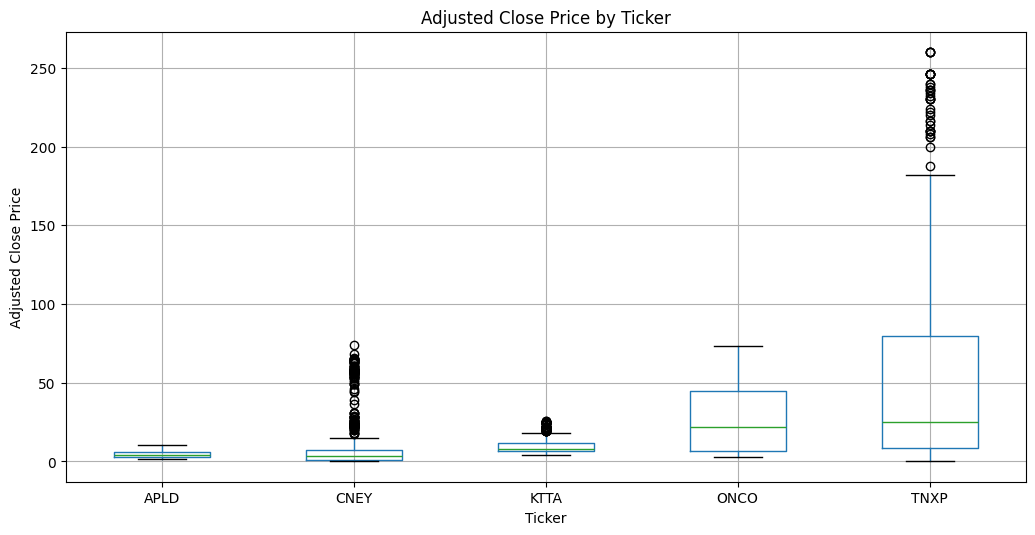

In [21]:
df.boxplot(column='Adjclose', by='Ticker', figsize=(12,6))
plt.ylabel('Adjusted Close Price')
plt.title('Adjusted Close Price by Ticker')
plt.suptitle('')
plt.show()

In [22]:
#show date range for each stock ticker - no date column, just index
for ticker in df.Ticker.unique():
    print(ticker, df[df.Ticker==ticker].index.min(), df[df.Ticker==ticker].index.max())

APLD 2022-09-26 00:00:00 2024-09-25 00:00:00
CNEY 2022-09-26 00:00:00 2024-09-25 00:00:00
KTTA 2022-09-26 00:00:00 2024-09-25 00:00:00
ONCO 2022-09-26 00:00:00 2024-09-25 00:00:00
TNXP 2022-09-26 00:00:00 2024-09-25 00:00:00


In [23]:
df[df.Ticker=='ONCO'].index.min().date()

datetime.date(2022, 9, 26)

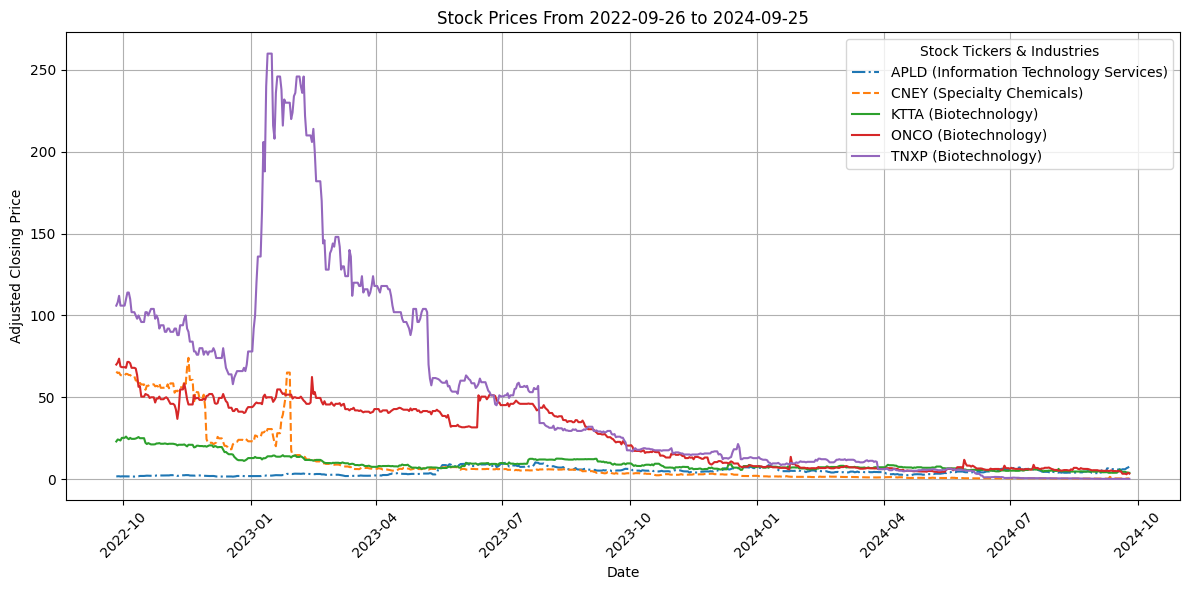

In [24]:
plt.figure(figsize=(12, 6))

# Get unique industries and define line styles
line_styles = ['-.', '--', '-', ':']  # Different line styles
style_map = {industry: line_styles[i % len(line_styles)] for i, industry in enumerate(df.Industry.unique())}

# Create a list to hold custom legend handles
legend_handles = []

# Loop through each ticker to plot
for ticker in df['Ticker'].unique():
    dfbyticker = df[df['Ticker'] == ticker]
    industry = dfbyticker['Industry'].iloc[0]  # Get the industry for the ticker
    line_style = style_map[industry]  # Get the line style for the industry
    
    # Plot the adjusted closing price
    line, = plt.plot(dfbyticker.index, dfbyticker['Adjclose'], 
                     label=ticker, 
                     linestyle=line_style)  # Apply the industry line style
    
    # Create a custom legend handle with the same color as the line
    legend_handles.append((industry, ticker, line.get_color(), line_style))  # Store as a tuple

# Create legend lines with appropriate colors (without sorting)
legend_lines = [mlines.Line2D([], [], color=color, linestyle=style, label=f'{ticker} ({industry})') 
                for industry, ticker, color, style in legend_handles]

plt.title(f'Stock Prices From {df[df.Ticker==ticker].index.min().date()} to {df[df.Ticker==ticker].index.max().date()}')
plt.xlabel('Date')
plt.ylabel('Adjusted Closing Price')
plt.xticks(rotation=45)

# Add the custom legend with colored handles
plt.legend(handles=legend_lines, title='Stock Tickers & Industries')

plt.grid()
plt.tight_layout()
plt.show()

### <a id='toc1_2_2_'></a>[Decomposition](#toc0_)

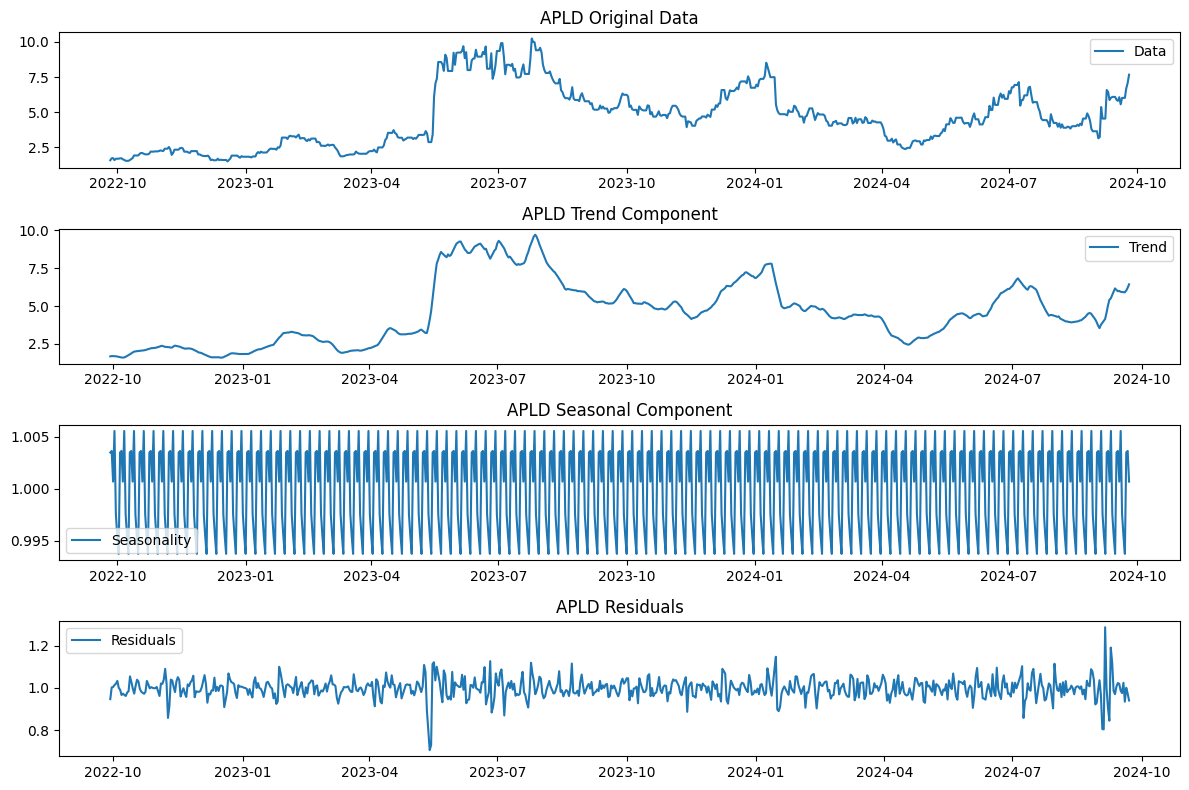

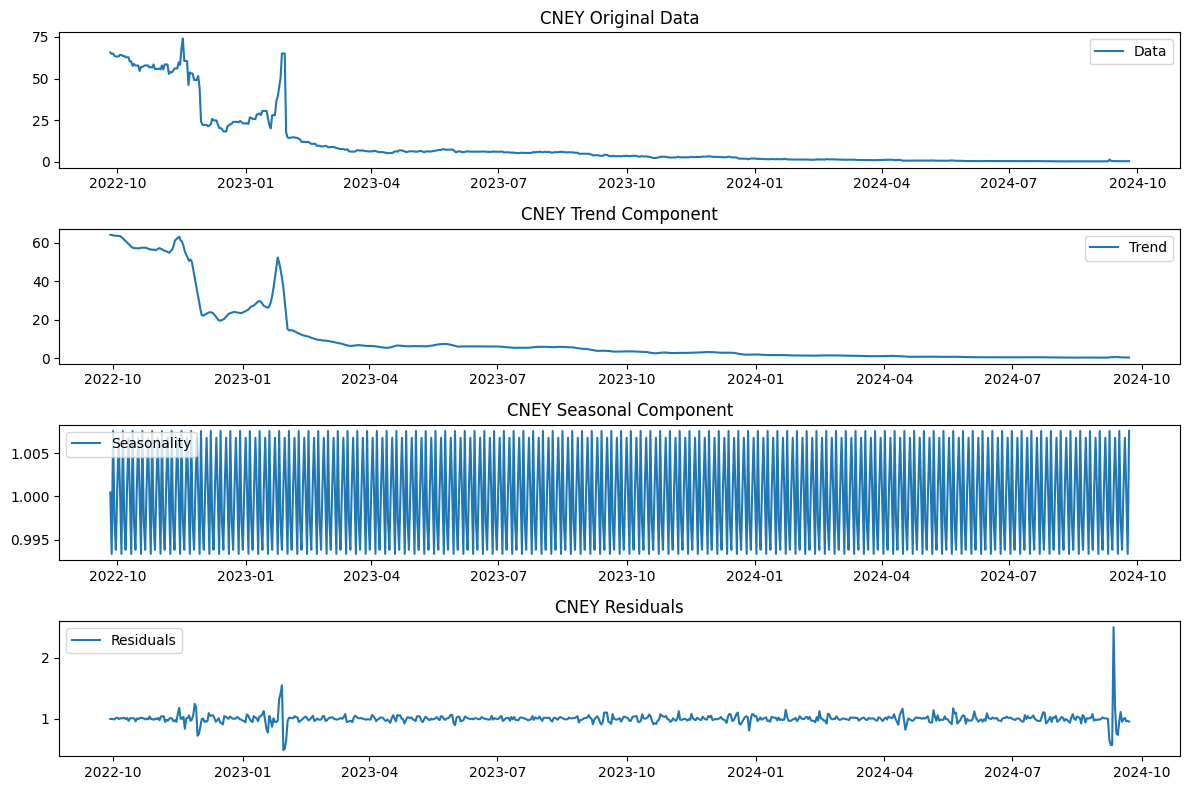

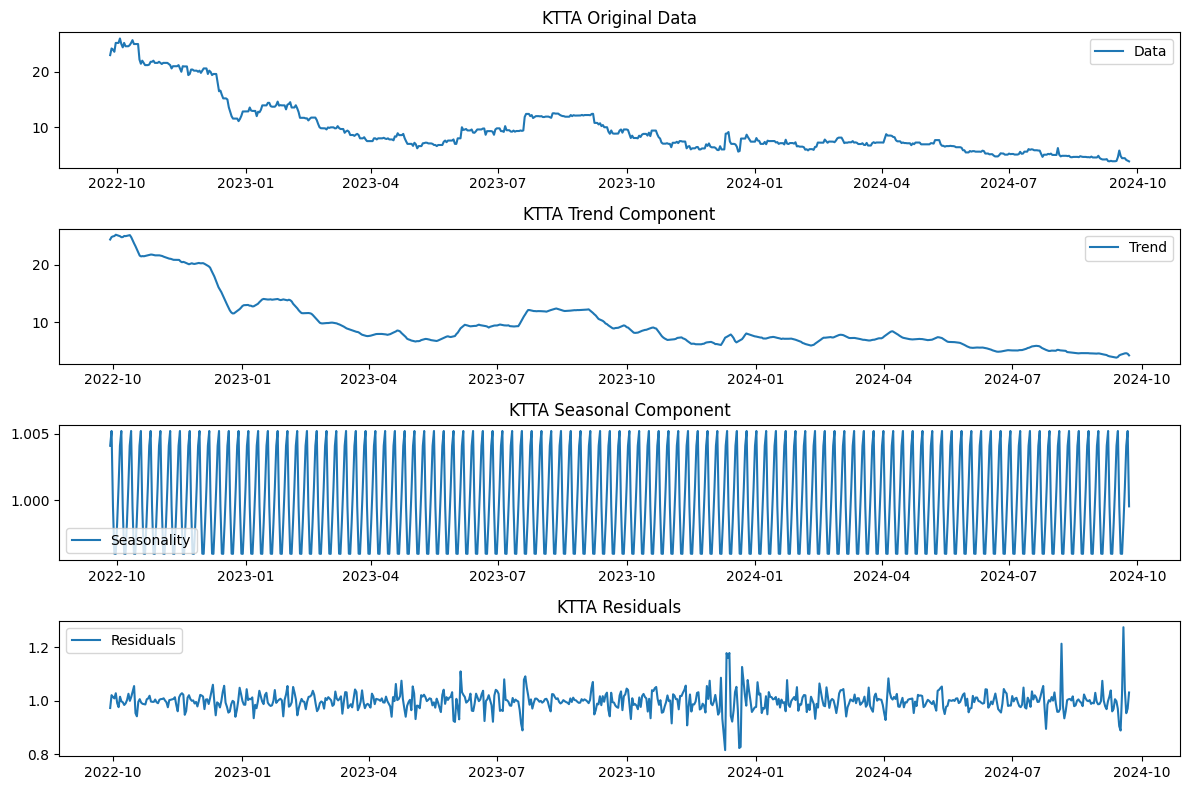

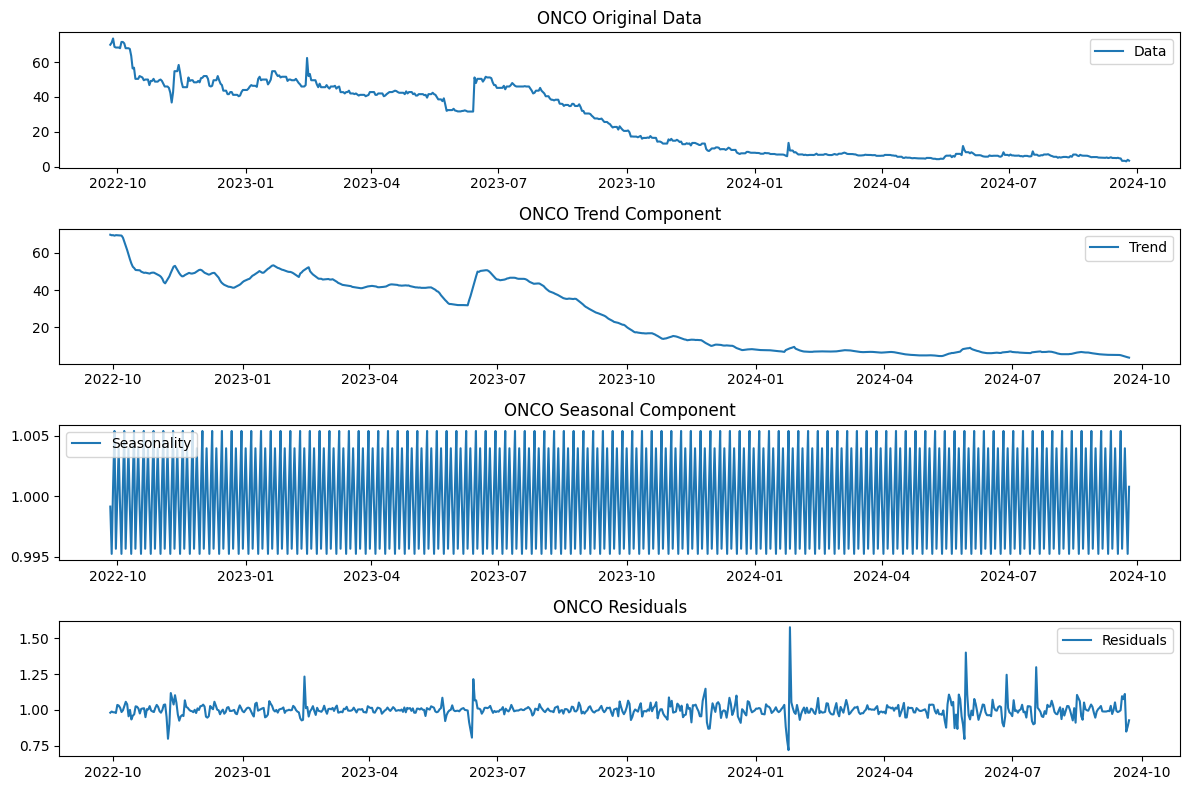

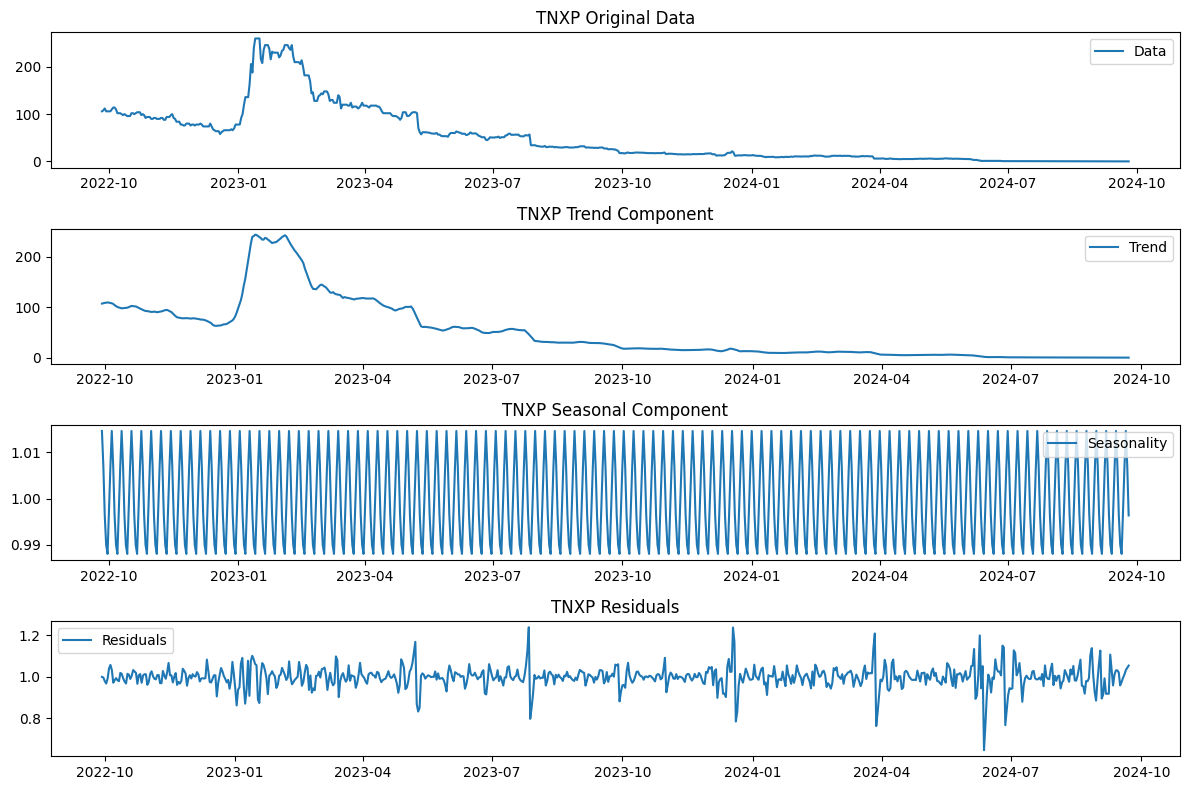

In [25]:
#plot each graph of seasonal decompose (multiplicative) for each ticker using Adjclose, list comprehension
seasonal_decompositions = [seasonal_decompose(df[df['Ticker'] == ticker]['Adjclose'], model='multiplicative')
                           for ticker in df['Ticker'].unique()]

for decomp, ticker in zip(seasonal_decompositions, df['Ticker'].unique()):
    plt.figure(figsize=(12, 8))

    plt.subplot(411)
    plt.plot(decomp.observed, label='Data')
    plt.title(f'{ticker} Original Data')
    plt.legend(loc='best')

    plt.subplot(412)
    plt.plot(decomp.trend, label='Trend')
    plt.title(f'{ticker} Trend Component')
    plt.legend(loc='best')

    plt.subplot(413)
    plt.plot(decomp.seasonal, label='Seasonality')
    plt.title(f'{ticker} Seasonal Component')
    plt.legend(loc='best')

    plt.subplot(414)
    plt.plot(decomp.resid, label='Residuals')
    plt.title(f'{ticker} Residuals')
    plt.legend(loc='best')

    plt.tight_layout()
    plt.show()



### <a id='toc1_2_3_'></a>[ADF Test for Stationarity](#toc0_)

In [26]:
for ticker in df.Ticker.unique():
    result=adfuller(df[df.Ticker==ticker].Adjclose)
    print(f'{ticker} ADF Statistic: {result[0]:.3f}, p-value: {result[1]:.3f}')

APLD ADF Statistic: -2.346, p-value: 0.158
CNEY ADF Statistic: -3.440, p-value: 0.010
KTTA ADF Statistic: -2.442, p-value: 0.130
ONCO ADF Statistic: -1.967, p-value: 0.301
TNXP ADF Statistic: -1.880, p-value: 0.341


The null hypothesis for the ADF Statistic is that the time series is non-stationary. We are able to reject the null at an alpha = 0.05 for only the CNEY series. Hence we conclude it is stationary from the ADF test.

In [27]:
df['Logdiff']=df.groupby('Ticker').Adjclose.transform(lambda x: np.log(x).diff())

In [28]:
df.groupby('Ticker').Logdiff.head()

Date
2022-09-26         NaN
2022-09-27    0.084387
2022-09-28    0.005764
2022-09-29   -0.083881
2022-09-30    0.060625
2022-09-26         NaN
2022-09-27   -0.013793
2022-09-28    0.004619
2022-09-29   -0.023311
2022-09-30   -0.004728
2022-09-26         NaN
2022-09-27    0.050858
2022-09-28   -0.008299
2022-09-29   -0.016807
2022-09-30    0.065597
2022-09-26         NaN
2022-09-27    0.016998
2022-09-28    0.033152
2022-09-29   -0.067441
2022-09-30   -0.005831
2022-09-26         NaN
2022-09-27    0.018692
2022-09-28    0.036368
2022-09-29   -0.055060
2022-09-30    0.000000
Name: Logdiff, dtype: float64

In [29]:
#drop nan rows from df
df.dropna(subset=['Logdiff'], inplace=True)
df.groupby('Ticker').Logdiff.head()


Date
2022-09-27    0.084387
2022-09-28    0.005764
2022-09-29   -0.083881
2022-09-30    0.060625
2022-10-01    0.000000
2022-09-27   -0.013793
2022-09-28    0.004619
2022-09-29   -0.023311
2022-09-30   -0.004728
2022-10-01    0.000000
2022-09-27    0.050858
2022-09-28   -0.008299
2022-09-29   -0.016807
2022-09-30    0.065597
2022-10-01    0.000000
2022-09-27    0.016998
2022-09-28    0.033152
2022-09-29   -0.067441
2022-09-30   -0.005831
2022-10-01    0.000000
2022-09-27    0.018692
2022-09-28    0.036368
2022-09-29   -0.055060
2022-09-30    0.000000
2022-10-01    0.000000
Name: Logdiff, dtype: float64

In [30]:
df.shape

(3650, 13)

In [31]:
for ticker in df.Ticker.unique():
    y=df[df.Ticker==ticker].Logdiff
    result=adfuller(y)
    print(f'{ticker} ADF Statistic (logged & diffed): {result[0]:.3f}, p-value: {result[1]:.3f}')

APLD ADF Statistic (logged & diffed): -26.588, p-value: 0.000
CNEY ADF Statistic (logged & diffed): -11.451, p-value: 0.000
KTTA ADF Statistic (logged & diffed): -11.969, p-value: 0.000
ONCO ADF Statistic (logged & diffed): -16.200, p-value: 0.000
TNXP ADF Statistic (logged & diffed): -24.918, p-value: 0.000


All tests conclude all stocks are now stationary except TNXP with the KPSS test. TNXP may be 

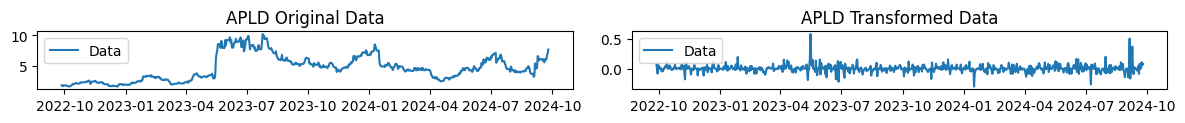

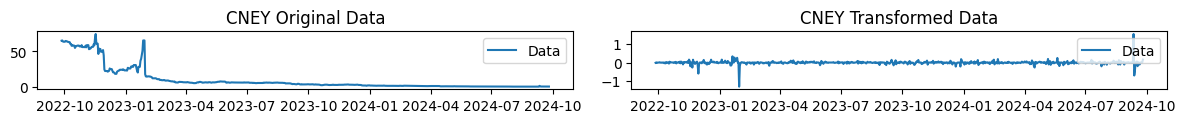

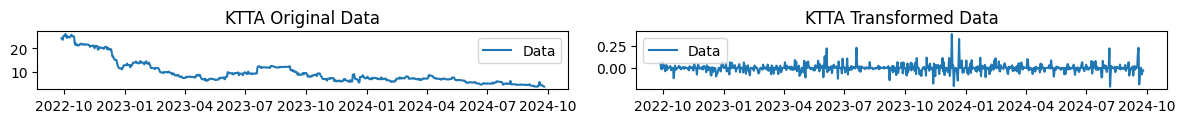

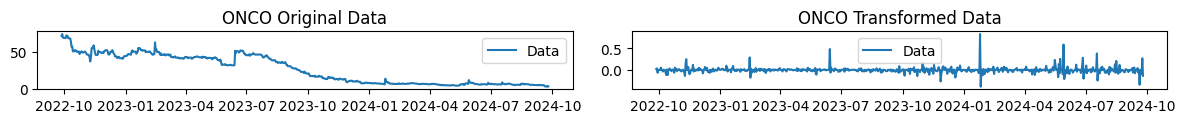

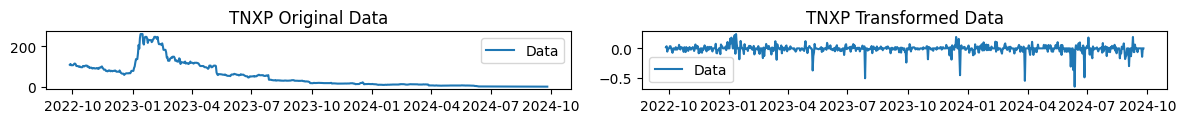

In [32]:
for ticker in df.Ticker.unique():
    y=df[df.Ticker==ticker].Adjclose
    newy=df[df.Ticker==ticker].Logdiff

    plt.figure(figsize=(12, 4))

    plt.subplot(421)
    plt.plot(y, label='Data')
    plt.title(f'{ticker} Original Data')
    plt.legend(loc='best')

    plt.subplot(422)
    plt.plot(newy, label='Data')
    plt.title(f'{ticker} Transformed Data')
    plt.legend(loc='best')

    plt.tight_layout()
    plt.show()

Each stock is now stationary as shown above. 

## <a id='toc1_3_'></a>[Correlation Matrix for Numerical Features](#toc0_)

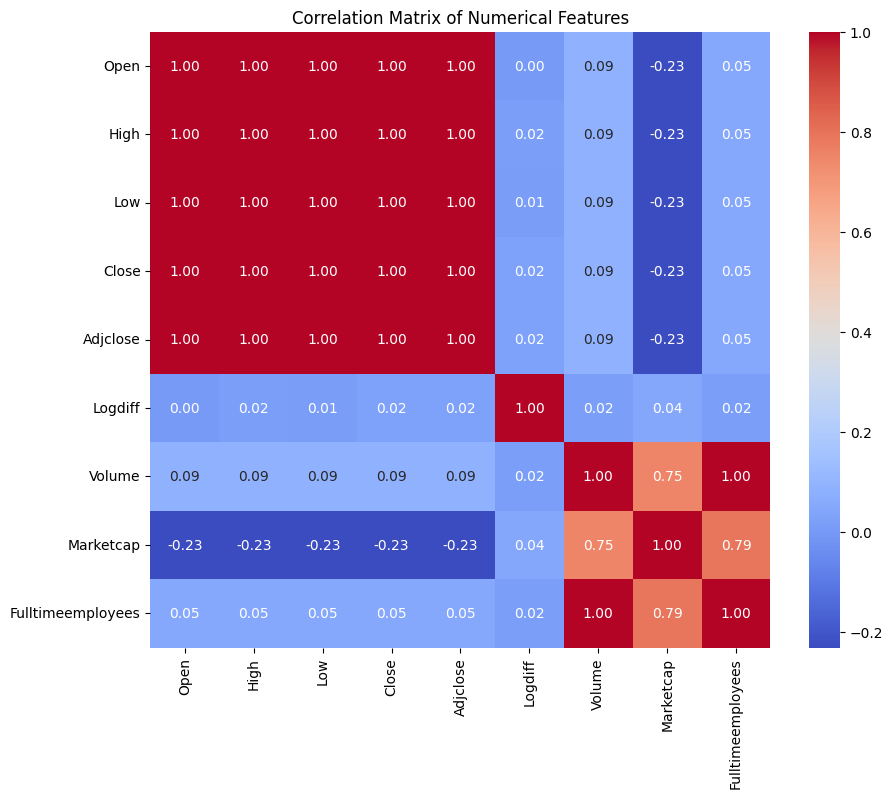

In [33]:
df_numerical = df[['Open', 'High', 'Low', 'Close', 'Adjclose', 'Logdiff', 'Volume', 'Marketcap', 'Fulltimeemployees']]
correlation_matrix = df_numerical.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

As assumed, open, high, low, close, and adjusted close prices are all identical parameters. 

## <a id='toc1_4_'></a>[Binary Target Variable](#toc0_)

In [34]:
#make predictive column for "To simplify the target variable, we ask that you use a binary classifier (1/0) that denotes whether there was a price increase (1) or not (0) from the previous trading day."
for ticker in df['Ticker'].unique():
    df.loc[df['Ticker'] == ticker, 'Priceincrease'] = (df[df['Ticker'] == ticker]['Adjclose'].diff() > 0).astype(int)
df.head()

,Ticker,Open,High,Low,Close,Adjclose,Volume,Industry,Sector,Marketcap,Fulltimeemployees,Companyinfo,Logdiff,Priceincrease
Date,,,,,,,,,,,,,,
2022-09-27,APLD,1.66,1.76,1.630,1.73,1.73,11024140,Information Technology Services,Technology,1625960576,150,"Applied Digital Corporation designs, develops,...",0.084387,0.0
2022-09-28,APLD,1.74,1.78,1.695,1.74,1.74,11024140,Information Technology Services,Technology,1625960576,150,"Applied Digital Corporation designs, develops,...",0.005764,1.0
2022-09-29,APLD,1.70,1.71,1.530,1.60,1.60,11024140,Information Technology Services,Technology,1625960576,150,"Applied Digital Corporation designs, develops,...",-0.083881,0.0
2022-09-30,APLD,1.59,1.81,1.590,1.70,1.70,11024140,Information Technology Services,Technology,1625960576,150,"Applied Digital Corporation designs, develops,...",0.060625,1.0
2022-10-01,APLD,1.59,1.81,1.590,1.70,1.70,11024140,Information Technology Services,Technology,1625960576,150,"Applied Digital Corporation designs, develops,...",0.000000,0.0


In [35]:
df.Priceincrease

Date
2022-09-27    0.0
2022-09-28    1.0
2022-09-29    0.0
2022-09-30    1.0
2022-10-01    0.0
             ... 
2024-09-21    0.0
2024-09-22    0.0
2024-09-23    0.0
2024-09-24    0.0
2024-09-25    0.0
Name: Priceincrease, Length: 3650, dtype: float64

# <a id='toc2_'></a>[Reddit data](#toc0_)

## <a id='toc2_1_'></a>[Import and Clean Data](#toc0_)

In [36]:
import datetime
import string
import re
import demoji
from urllib.parse import urlparse
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon', 'stopwords', 'punkt', 'wordnet')

True

In [37]:
rdf=pd.read_csv('reddit.csv')
rdf.head()

,ticker,subreddit,query,title,score,id,author,url,post_date,selftext,num_comments,comments
0,APLD,wallstreetbets,APLD,Found a newspaper from 2011. Imagine all the g...,5108,1aryoah,nywarpath,https://i.redd.it/s7q97fka9vic1.jpeg,2024-02-16 03:26:31,NaN,688,[{'comment': '\n**User Report**| | | |\n:--|:-...
1,APLD,wallstreetbets,APLD,Micro Trading Options on QQQ!,316,1fbjdhn,Vivo__,https://i.redd.it/vd1e4xdqugnd1.jpeg,2024-09-07 22:48:32,The good side to options is its worst side! Yo...,153,[{'comment': '\n**User Report**| | | |\n:--|:-...
2,APLD,wallstreetbets,APLD,Most Anticipated Earnings Releases for the wee...,260,194hj19,ItsNotYourFault,https://i.redd.it/d2nn39ignwbc1.png,2024-01-12 00:37:59,NaN,244,[{'comment': 'Not open on MLK Day? He’d want p...
3,APLD,wallstreetbets,APLD,Dow drops more than 400 points as Wall Street ...,214,1bu74lx,mediterranean2,https://www.reddit.com/r/wallstreetbets/commen...,2024-04-02 19:07:01,The Dow Jones Industrial Average\n fell for a ...,54,[{'comment': '\n**User Report**| | | |\n:--|:-...
4,APLD,stocks,APLD,(9/20) Friday's Pre-Market News & Stock Movers,18,1flatw5,bigbear0083,https://www.reddit.com/r/stocks/comments/1flat...,2024-09-20 12:30:23,#Good Friday morning traders and investors of ...,0,[]


In [38]:
rdf.shape

(818, 12)

In [39]:
rdf.post_date=pd.to_datetime(rdf.post_date)

In [40]:
#search for rows with same id
rdf[rdf.duplicated(subset='id', keep=False)].sort_values(by='id')

,ticker,subreddit,query,title,score,id,author,url,post_date,selftext,num_comments,comments
732,TNXP,shortsqueeze,Tonix,#TNXP TONIX IS A LITTLE FISH IN A SEA OF SHARK...,0,1030xmu,neverbackdowm,https://www.reddit.com/r/Shortsqueeze/comments...,2023-01-04 11:06:29,Tonix does not produce anything yet but has a ...,5,[{'comment': 'get ready for some fireworks… ov...
635,TNXP,shortsqueeze,TNXP,#TNXP TONIX IS A LITTLE FISH IN A SEA OF SHARK...,1,1030xmu,neverbackdowm,https://www.reddit.com/r/Shortsqueeze/comments...,2023-01-04 11:06:29,Tonix does not produce anything yet but has a ...,5,[{'comment': 'get ready for some fireworks… ov...
786,TNXP,tnxp,Tonix,#TNXP TONIX IS A LITTLE FISH IN A SEA OF SHARK...,0,1030xri,neverbackdowm,/r/Shortsqueeze/comments/1030xmu/tnxp_tonix_is...,2023-01-04 11:06:42,NaN,4,"[{'comment': 'TNXP is the shark, the sharehol..."
701,TNXP,tnxp,TNXP,#TNXP TONIX IS A LITTLE FISH IN A SEA OF SHARK...,1,1030xri,neverbackdowm,/r/Shortsqueeze/comments/1030xmu/tnxp_tonix_is...,2023-01-04 11:06:42,NaN,4,"[{'comment': 'TNXP is the shark, the sharehol..."
745,TNXP,stockinvest,Tonix,TNXP Price Predictions - Tonix Pharmaceuticals...,4,108azi5,TheWizzr,https://www.youtube.com/watch?v=819XUIfvj4k,2023-01-10 14:20:54,NaN,0,[]
...,...,...,...,...,...,...,...,...,...,...,...,...
651,TNXP,stocktitan,TNXP,TNXP | Tonix Pharmaceuticals Announces Issuanc...,2,1fki0so,Stock_Titan,https://www.stocktitan.net/news/TNXP/tonix-pha...,2024-09-19 11:00:03,NaN,0,[]
456,CNEY,pennystocks,CN energy,3 penny stocks that might help you achieve fin...,75,1fknz7h,Stocksy1234,https://www.reddit.com/r/pennystocks/comments/...,2024-09-19 15:43:36,Hey! Here are some of the main stocks that I h...,30,[{'comment': '\nDoes this submission fit our s...
22,APLD,pennystocks,APLD,3 penny stocks that might help you achieve fin...,72,1fknz7h,Stocksy1234,https://www.reddit.com/r/pennystocks/comments/...,2024-09-19 15:43:36,Hey! Here are some of the main stocks that I h...,30,[{'comment': '\nDoes this submission fit our s...
530,KTTA,stocktitan,pasithea therapeutics,KTTA | Pasithea Therapeutics to Call Special M...,1,xv3f3b,Stock_Titan,https://www.stocktitan.net/news/KTTA/pasithea-...,2022-10-04 02:54:32,NaN,0,[]


In [41]:
#drop duplicates by id
rdf.drop_duplicates(subset='id', inplace=True)

In [42]:
rdf.shape

(722, 12)

In [43]:
rdf.groupby('ticker').size()

ticker
APLD    405
CNEY     84
KTTA      9
ONCO     52
TNXP    172
dtype: int64

KTTA value counts are too low. Drop from both datasets.

In [44]:
#drop rows with KTTA ticker 
df=df[df.Ticker!='KTTA']
rdf=rdf[rdf.ticker!='KTTA']

In [45]:
rdf.title.isna().sum()

0

In [46]:
#check for more duplicates
rdf[rdf.title.duplicated()==True].sort_values(by='title').head()

,ticker,subreddit,query,title,score,id,author,url,post_date,selftext,num_comments,comments
701,TNXP,tnxp,TNXP,#TNXP TONIX IS A LITTLE FISH IN A SEA OF SHARK...,1,1030xri,neverbackdowm,/r/Shortsqueeze/comments/1030xmu/tnxp_tonix_is...,2023-01-04 11:06:42,NaN,4,"[{'comment': 'TNXP is the shark, the sharehol..."
57,APLD,stockbreakouts,APLD,$APLD By Far The Greatest Swing Play Of The We...,1,13nhdkl,YGLD,https://i.redd.it/tm0gjxpo851b1.jpg,2023-05-21 03:16:48,NaN,0,[]
58,APLD,stockbreakouts,APLD,$APLD Trading Plan Posted BEFORE The Bell 🚨 - ...,2,13jgqsy,YGLD,https://www.reddit.com/gallery/13jgqsy,2023-05-16 20:47:02,NaN,0,[]
71,APLD,wallstreet,APLD,$APLD Trading Plan Posted BEFORE The Bell 🚨 - ...,1,13jhwbh,YGLD,https://www.reddit.com/gallery/13jgqsy,2023-05-16 21:32:07,NaN,0,[]
437,CNEY,wallstreet,CNEY,$CNEY Incredible Move For Whats Been A Rough S...,2,1feghct,YGLD,https://i.redd.it/iemh2d7ex7od1.jpeg,2024-09-11 17:51:59,NaN,0,[]


In [47]:
rdf.shape

(713, 12)

In [48]:
rdf.rename(columns={'selftext':'post'}, inplace=True)

In [49]:
#check for more duplicates
rdf[(rdf.title.duplicated()==True)&(rdf.post_date.duplicated()==True)]

,ticker,subreddit,query,title,score,id,author,url,post_date,post,num_comments,comments


A lot of posts are posted by the same guy across multiple dates. 

In [50]:
rdf.reset_index(drop=True, inplace=True)

## <a id='toc2_2_'></a>[Preprocessing and Univariate Analysis](#toc0_)

### <a id='toc2_2_1_'></a>[Posts](#toc0_)

In [51]:
rdf.post


0                                                    NaN
1      The good side to options is its worst side! Yo...
2                                                    NaN
3      The Dow Jones Industrial Average\n fell for a ...
4      #Good Friday morning traders and investors of ...
                             ...                        
708                                                  NaN
709    62% short interest, 560% ctb ( 1,132% max), an...
710     Tonix Pharmaceuticals Holding Corp. announced...
711                                                  NaN
712                                                  NaN
Name: post, Length: 713, dtype: object

In [52]:
rdf.post.fillna('', inplace=True)
rdf.post_date=rdf.post_date.dt.date

In [221]:
rdf

,ticker,subreddit,query,title,score,id,author,url,post_date,post,num_comments,comments,post_sentiment_score,title_sentiment_score,daily_post_sentiment_score
0,APLD,wallstreetbets,APLD,Found a newspaper from 2011. Imagine all the g...,5108,1aryoah,nywarpath,https://i.redd.it/s7q97fka9vic1.jpeg,2024-02-16,,688,[{'comment': '\n**User Report**| | | |\n:--|:-...,0.0000,-0.3182,0.00000
1,APLD,wallstreetbets,APLD,Micro Trading Options on QQQ!,316,1fbjdhn,Vivo__,https://i.redd.it/vd1e4xdqugnd1.jpeg,2024-09-07,The good side to options is its worst side! Yo...,153,[{'comment': '\n**User Report**| | | |\n:--|:-...,0.6785,0.0000,0.81975
2,APLD,wallstreetbets,APLD,Most Anticipated Earnings Releases for the wee...,260,194hj19,ItsNotYourFault,https://i.redd.it/d2nn39ignwbc1.png,2024-01-12,,244,[{'comment': 'Not open on MLK Day? He’d want p...,0.0000,0.0000,0.00000
3,APLD,wallstreetbets,APLD,Dow drops more than 400 points as Wall Street ...,214,1bu74lx,mediterranean2,https://www.reddit.com/r/wallstreetbets/commen...,2024-04-02,The Dow Jones Industrial Average\n fell for a ...,54,[{'comment': '\n**User Report**| | | |\n:--|:-...,0.1027,0.0000,0.10270
4,APLD,stocks,APLD,(9/20) Friday's Pre-Market News & Stock Movers,18,1flatw5,bigbear0083,https://www.reddit.com/r/stocks/comments/1flat...,2024-09-20,#Good Friday morning traders and investors of ...,0,[],0.9393,0.0000,0.96820
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
708,TNXP,tnxp,Tonix,Hopefully the upcoming presentation creates so...,3,1d1bybq,Joey164,https://i.redd.it/yy5qvt50cu2d1.jpeg,2024-05-26,,14,"[{'comment': 'I am holding too..', 'comment_au...",0.0000,0.6580,0.00000
709,TNXP,tnxp,Tonix,Worth a look!,0,1dtclc5,Joey164,https://www.reddit.com/r/TNXP/comments/1dtclc5...,2024-07-02,"62% short interest, 560% ctb ( 1,132% max), an...",2,"[{'comment': 'Zoom out - worth a look', 'comme...",0.7177,0.2942,0.00000
710,TNXP,tnxp,Tonix,You wonder why they did a buyback?,8,10pzco8,Banished_Privateer,https://www.reddit.com/r/TNXP/comments/10pzco8...,2023-01-31,Tonix Pharmaceuticals Holding Corp. announced...,21,[{'comment': 'If they do another reverse split...,0.6908,0.0000,0.69080
711,TNXP,tnxp,Tonix,Going back to 0.04 cents soon lol,8,12y7ya1,Bashir-Sangawi,https://www.reddit.com/r/TNXP/comments/12y7ya1...,2023-04-25,,6,[{'comment': 'Tonix cost me 10k with that last...,0.0000,0.4215,0.00000


In [219]:
post_count=rdf.groupby(['ticker', 'post_date']).size().reset_index(level=0)
post_count.columns=['ticker', 'count']
#set index to datetime
post_count.index=pd.to_datetime(post_count.index)
#group by ticker and resample daily and fill the empty count dates with 0 
post_count=post_count.resample('D').asfreq().fillna(0)

ValueError: cannot reindex on an axis with duplicate labels

In [201]:
#create daily post_count for each ticker in a new post_count dataframe and set index to date from 2022-09-26 to 2024-09-25
post_count=rdf.groupby(['ticker', 'post_date']).size().unstack(level=0, fill_value=0)
post_count.index=pd.date_range(start='2022-09-26', end='2024-09-25', freq='D')
post_count

ValueError: Length mismatch: Expected axis has 401 elements, new values have 731 elements

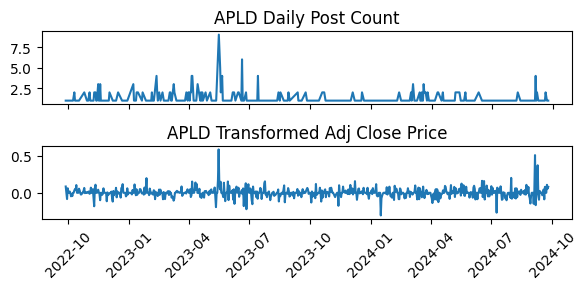

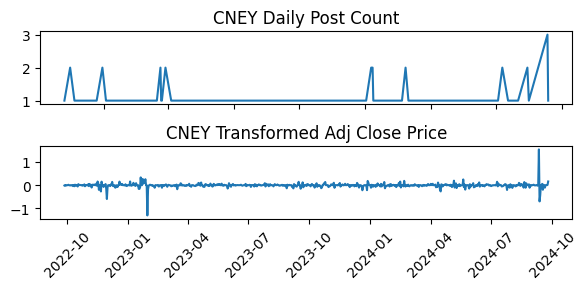

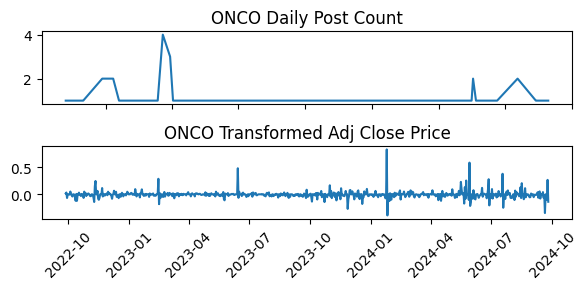

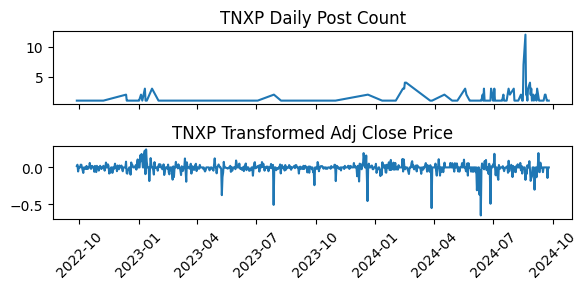

''

In [53]:
for ticker in df.Ticker.unique():
    y = rdf[rdf.ticker == ticker].groupby('post_date').size()
    newy = df[df.Ticker == ticker].Logdiff

    plt.figure(figsize=(6, 3))

    plt.subplot(211)  # This places the first plot in the upper half of the figure
    plt.plot(y.index, y, label='Daily Post Count')
    plt.title(f'{ticker} Daily Post Count')
    plt.xticks(visible=False)  # Rotate dates for better visibility

    plt.subplot(212)  # This places the second plot in the lower half of the figure
    plt.plot(newy.index, newy, label='Transformed Adj Close Price')
    plt.title(f'{ticker} Transformed Adj Close Price')
    plt.xticks(rotation=45)  # Rotate dates for better visibility

    plt.tight_layout()
    plt.show()
''''''
#no i want it to be like.. for each ticker, plot the daily post count graph above the transformed adj close price 


### <a id='toc2_2_2_'></a>[Text Preprocessing for EDA (Not for sentiment analysis & modeling)](#toc0_)

In [54]:
print(textwrap.fill(rdf.post[79], width=80))

⚠️ *Attention all traders and holders of Chinese stocks:*   *You should read
this if you don’t know what a VIE is. Sure, most of you will be repelled by the
great wall of text here (so many words!), but you might want to keep this post
nearby.*    Hello.   You are aware that Wall Street’s bustling bazaar hosts a
veritable Forbidden City of Chinese companies draped in ticker tape rather than
silk.   Today, I will provide background and data on all allowed Chinese
companies listed on three of the largest U.S. stock exchanges: New York Stock
Exchange (NYSE), Nasdaq, and NYSE American.  I should note that a bustling
troupe of 26 national securities exchanges are registered with the SEC in the
United States. Most are owned by the Nasdaq, NYSE, or the Chicago Board Options
Exchange (CBOE).  Nonetheless, based on data from the [World Federation of
Exchanges](https://www.world-exchanges.org) as of August 2023, the NYSE and
Nasdaq were the top two exchanges behemoths of the global financial sta

In [55]:
def clean(s):
    s=re.sub(r'[[\]]', ' ', s)
    urls = re.findall(r'https?://[^\s]+', s)
    for url in urls:
        domain_parts = urlparse(url).netloc.split('.')
        if len(domain_parts) > 1:
            domain = 'url' + domain_parts[1]  # Use the second part of the domain
        else:
            domain = 'urlDomain'  # Default value if domain part is missing
        s = s.replace(url, domain)
    
    s=s.lower()
    s=s.replace('u.s.', ' united states ')
    s=re.sub(r'\d+', ' ', s)
    #remove punctuation
    s = s.translate(str.maketrans('', '', string.punctuation))
    #remove ’
    s=s.replace('’', '').replace('—', ' ')
    #s=s.translate(str.maketrans(string.punctuation, ' '*len(string.punctuation)))
    #remove emojis
    s=demoji.replace(s, '')
    #s=s.translate(str.maketrans('', '', string.punctuation))
    #tokenizer = RegexpTokenizer(r'\bU\.S\.|\w+|\$[\d\.]+|\S+')
    #s=tokenizer.tokenize(s)
    tokens=word_tokenize(s)
    sw=stopwords.words('english')+['im', 'ive', 'since', 'cant', 'he', 'thing', 'ago', 'also', 'dont', 'ah', \
                                   'hes', 'shes', 'u', 'going', 'like', 'one', 'two', 'got', 'get', 'gonna', \
                                      'know', 'would', 'go', 'maybe', 'really', 'could', 'should']
    filtered_tokens=[word for word in tokens if word not in sw]

    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]
    
    return ' '.join(lemmatized_tokens)

In [56]:
print(textwrap.fill(clean(rdf.post[79]), width=80))

/tmp/ipykernel_2262/1487377036.py:2: FutureWarning: Possible nested set at position 1
  s=re.sub(r'[[\]]', ' ', s)


attention trader holder chinese stock read vie sure repelled great wall text
many word might want keep post nearby hello aware wall street bustling bazaar
host veritable forbidden city chinese company draped ticker tape rather silk
today provide background data allowed chinese company listed three largest
united state stock exchange new york stock exchange nyse nasdaq nyse american
note bustling troupe national security exchange registered sec united state
owned nasdaq nyse chicago board option exchange cboe nonetheless based data
world federation exchange urlworldexchanges august nyse nasdaq top exchange
behemoth global financial stage accounting total trillion valuation traded
across major global exchange photo wall street add allowed include attachment v
according united state china economic security review commission january chinese
company listed three united state exchange total market capitalization billion
valuation year prior january slightly lower chinese company tracked repr

In [57]:
rdf.cleaned_post=rdf.post.apply(clean)

/tmp/ipykernel_2262/2374111883.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  rdf.cleaned_post=rdf.post.apply(clean)


In [58]:
rdf.cleaned_post.head()

0                                                     
1    good side option worst side make ton loose ton...
2                                                     
3    dow jones industrial average fell second day c...
4    good friday morning trader investor rstocks su...
Name: post, dtype: object

## <a id='toc2_2_3_'></a>[VADER Sentiment Analysis](#toc0_)

### Titles

In [98]:
from scipy.stats import shapiro


In [96]:
sia = SentimentIntensityAnalyzer()

def get_sentiment(s):
    s=re.sub(r'[[\]]', ' ', s)
    urls = re.findall(r'https?://[^\s]+', s)
    for url in urls:
        domain_parts = urlparse(url).netloc.split('.')
        if len(domain_parts) > 1:
            domain = 'url' + domain_parts[1]  # Use the second part of the domain
        else:
            domain = 'urlDomain'  # Default value if domain part is missing
        s = s.replace(url, domain)
    
    cleaned_text=s.replace('\n', ' ').replace('\r', ' ').replace('\t', ' ')

    return sia.polarity_scores(cleaned_text)['compound']

In [90]:
rdf['title_sentiment_score']=rdf.title.apply(get_sentiment)

In [102]:
rdf.groupby('ticker').title_sentiment_score.describe()

,count,mean,std,min,25%,50%,75%,max
ticker,,,,,,,,
APLD,405.0,0.115264,0.332550,-0.8176,0.0,0.0000,0.361200,0.9215
CNEY,84.0,0.214337,0.288746,-0.4588,0.0,0.1531,0.381800,0.9153
ONCO,52.0,0.077756,0.234007,-0.4215,0.0,0.0000,0.250000,0.6808
TNXP,172.0,0.074435,0.321075,-0.7650,0.0,0.0000,0.207825,0.8800


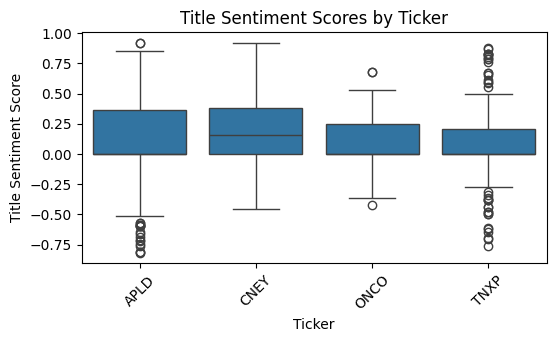

In [97]:
#plot boxplot of post sentiment scores by ticker
plt.figure(figsize=(6, 3))
sns.boxplot(x='ticker', y='title_sentiment_score', data=rdf)
plt.title('Title Sentiment Scores by Ticker')
plt.ylabel('Title Sentiment Score')
plt.xlabel('Ticker')
plt.xticks(rotation=45)
plt.show()



In [100]:
for ticker in rdf.ticker.unique():
    data = rdf[rdf.ticker == ticker].title_sentiment_score
    stat, p = shapiro(data)
    print(f'{ticker} Shapiro-Wilk Test: Statistics={stat:.3f}, p={p:.3f}')

APLD Shapiro-Wilk Test: Statistics=0.911, p=0.000
CNEY Shapiro-Wilk Test: Statistics=0.903, p=0.000
ONCO Shapiro-Wilk Test: Statistics=0.814, p=0.000
TNXP Shapiro-Wilk Test: Statistics=0.849, p=0.000


Title sentiment scores are not normally distributed for each ticker. We can use the median to compute daily scores.

In [165]:
#get daily post sentiment scores with medians for each ticker (put ticker in a column) and set date as index and resample to daily for each ticker
daily_title_sentiment = rdf.groupby(['ticker', 'post_date']).title_sentiment_score.median()

In [166]:
#make new column ticker from multiindex and leave the date as datetimeindex
daily_title_sentiment = daily_title_sentiment.reset_index().set_index('post_date')

In [167]:
#datetime index
daily_title_sentiment.index = pd.to_datetime(daily_title_sentiment.index)

In [160]:
#groupby ticker and resample to daily and fill empty dates with 0 
daily_title_sentiment = daily_title_sentiment.groupby('ticker').resample('D').median().fillna(0)


In [191]:
# Define the date range from 2022-09-26 to 2024-09-25
date_range = pd.date_range(start='2022-09-26', end='2024-09-25', freq='D')

# Group by ticker and post_date, calculate median sentiment, and reset index
daily_title_sentiment = (
    rdf.groupby(['ticker', 'post_date'])
    .title_sentiment_score.median()
    .reset_index()
)

# Ensure post_date is in datetime format
daily_title_sentiment['post_date'] = pd.to_datetime(daily_title_sentiment['post_date'])

# Create a MultiIndex to cover all dates for all tickers
tickers = daily_title_sentiment['ticker'].unique()
full_index = pd.MultiIndex.from_product([tickers, date_range], names=['ticker', 'post_date'])

# Reindex the DataFrame to ensure all tickers have all dates, filling missing values with 0
daily_title_sentiment = (
    daily_title_sentiment.set_index(['ticker', 'post_date'])
    .reindex(full_index, fill_value=0)
    .reset_index()
)

# Set post_date as index and ensure the column order is correct
daily_title_sentiment.set_index('post_date', inplace=True)



In [192]:
daily_title_sentiment

,ticker,title_sentiment_score
post_date,,
2022-09-26,APLD,0.0000
2022-09-27,APLD,-0.0325
2022-09-28,APLD,0.0000
2022-09-29,APLD,0.0000
2022-09-30,APLD,0.0000
...,...,...
2024-09-21,TNXP,0.0000
2024-09-22,TNXP,0.0000
2024-09-23,TNXP,-0.6114


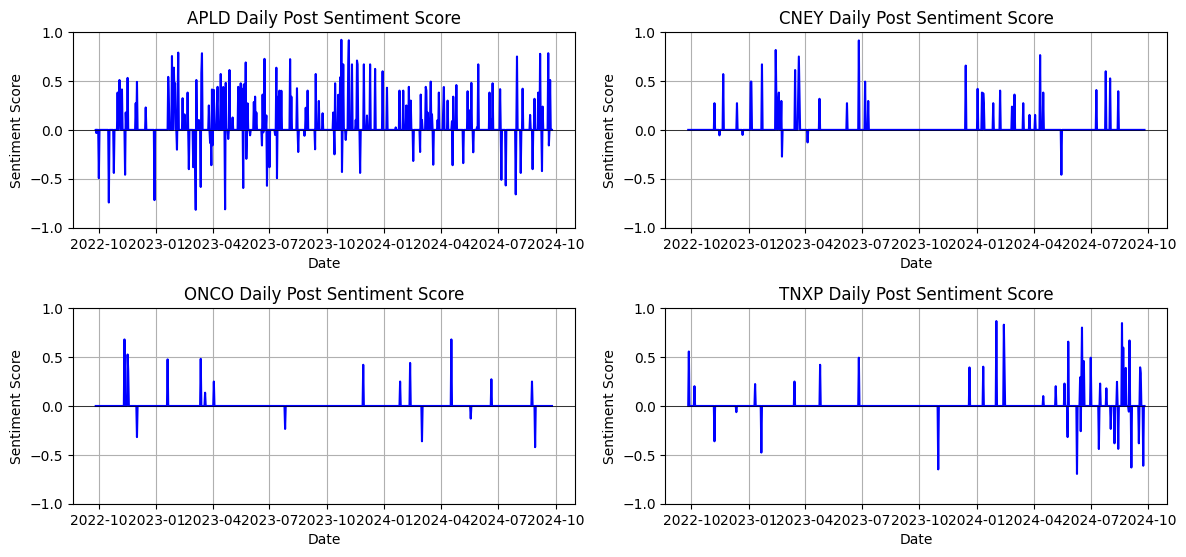

In [194]:
plt.figure(figsize=(12, 8))
for i, ticker in enumerate(daily_title_sentiment.ticker.unique()):
    data = daily_title_sentiment[daily_title_sentiment.ticker == ticker]
    plt.subplot(3, 2, i+1)
    plt.plot(data.index, data.title_sentiment_score, label='Sentiment', color='blue')
    plt.title(f'{ticker} Daily Post Sentiment Score')
    plt.xlabel('Date')
    plt.ylabel('Sentiment Score')
    plt.ylim(-1, 1)
    plt.grid()
    plt.axhline(0, color='black', linewidth=0.5)
plt.tight_layout()
plt.show()

### Posts

In [180]:
rdf['post_sentiment_score']=rdf.post.apply(get_sentiment)

In [181]:
rdf.groupby('ticker').post_sentiment_score.describe()

,count,mean,std,min,25%,50%,75%,max
ticker,,,,,,,,
APLD,405.0,0.667729,0.525228,-0.9992,0.2105,0.9845,0.998500,1.0000
CNEY,84.0,0.686892,0.487078,-0.9941,0.0000,0.9897,0.998025,0.9997
ONCO,52.0,0.355846,0.487284,-0.9185,0.0000,0.2920,0.812075,0.9935
TNXP,172.0,0.186488,0.426516,-0.8734,0.0000,0.0000,0.458800,0.9998


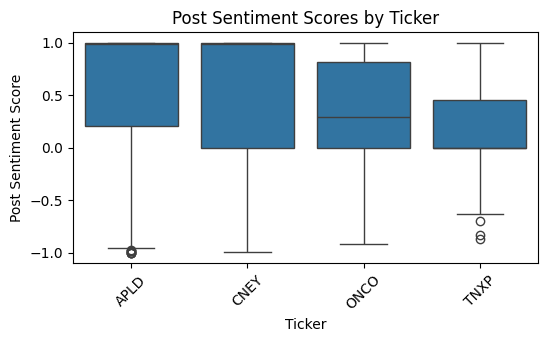

In [182]:
#plot boxplot of post sentiment scores by ticker
plt.figure(figsize=(6, 3))
sns.boxplot(x='ticker', y='post_sentiment_score', data=rdf)
plt.title('Post Sentiment Scores by Ticker')
plt.ylabel('Post Sentiment Score')
plt.xlabel('Ticker')
plt.xticks(rotation=45)
plt.show()



In [183]:
for ticker in rdf.ticker.unique():
    data = rdf[rdf.ticker == ticker].post_sentiment_score
    stat, p = shapiro(data)
    print(f'{ticker} Shapiro-Wilk Test: Statistics={stat:.3f}, p={p:.3f}')


APLD Shapiro-Wilk Test: Statistics=0.665, p=0.000
CNEY Shapiro-Wilk Test: Statistics=0.644, p=0.000
ONCO Shapiro-Wilk Test: Statistics=0.917, p=0.001
TNXP Shapiro-Wilk Test: Statistics=0.802, p=0.000


In [184]:
# Define the date range from 2022-09-26 to 2024-09-25
date_range = pd.date_range(start='2022-09-26', end='2024-09-25', freq='D')

# Group by ticker and post_date, calculate median sentiment, and reset index
daily_post_sentiment = (
    rdf.groupby(['ticker', 'post_date'])
    .post_sentiment_score.median()
    .reset_index()
)

# Ensure post_date is in datetime format
daily_post_sentiment['post_date'] = pd.to_datetime(daily_post_sentiment['post_date'])

# Create a MultiIndex to cover all dates for all tickers
tickers = daily_post_sentiment['ticker'].unique()
full_index = pd.MultiIndex.from_product([tickers, date_range], names=['ticker', 'post_date'])

# Reindex the DataFrame to ensure all tickers have all dates, filling missing values with 0
daily_post_sentiment = (
    daily_post_sentiment.set_index(['ticker', 'post_date'])
    .reindex(full_index, fill_value=0)
    .reset_index()
)

# Set post_date as index and ensure the column order is correct
daily_post_sentiment.set_index('post_date', inplace=True)



In [187]:
daily_post_sentiment

,ticker,post_sentiment_score
post_date,,
2022-09-26,APLD,0.0000
2022-09-27,APLD,0.9999
2022-09-28,APLD,0.0000
2022-09-29,APLD,0.0000
2022-09-30,APLD,0.9709
...,...,...
2024-09-21,TNXP,0.0000
2024-09-22,TNXP,0.5574
2024-09-23,TNXP,-0.6008


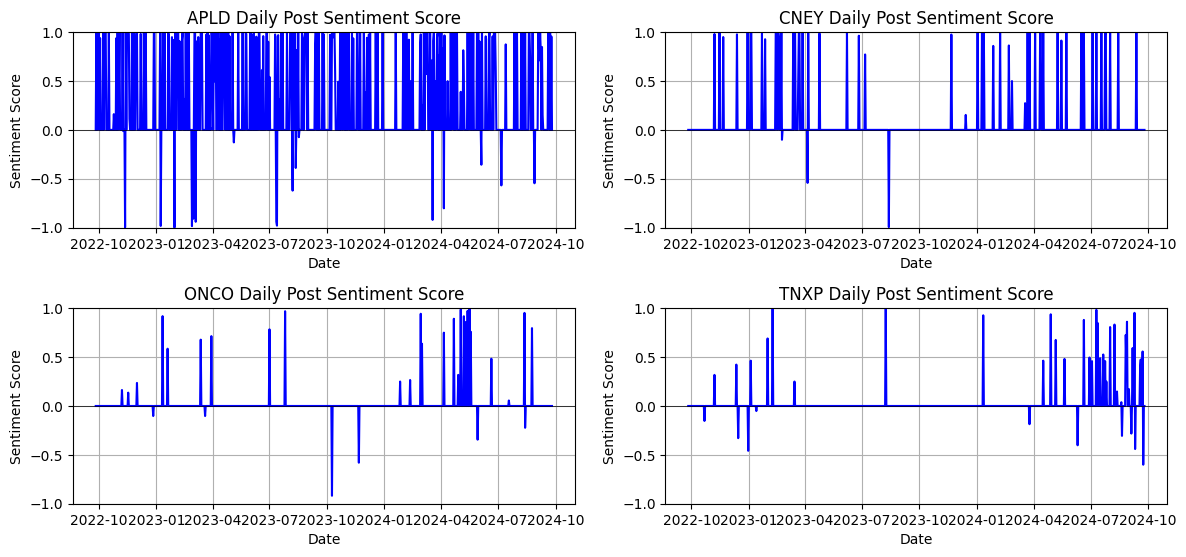

In [197]:
plt.figure(figsize=(12, 8))
for i, ticker in enumerate(daily_post_sentiment.ticker.unique()):
    data = daily_post_sentiment[daily_post_sentiment.ticker == ticker]
    plt.subplot(3, 2, i+1)
    plt.plot(data.index, data.post_sentiment_score, label='Sentiment', color='blue')
    plt.title(f'{ticker} Daily Post Sentiment Score')
    plt.xlabel('Date')
    plt.ylabel('Sentiment Score')
    plt.ylim(-1, 1)
    plt.grid()
    plt.axhline(0, color='black', linewidth=0.5)
plt.tight_layout()
plt.show()

In [190]:
'''plt.figure(figsize=(12, 8))

# Get unique tickers
unique_tickers = rdf['ticker'].unique()

# Loop through each ticker and create a subplot
for i, ticker in enumerate(unique_tickers):

    # Select the data for the current ticker
    data = rdf[rdf.ticker == ticker]
    
    # Calculate daily mean sentiment
    daily_mean_sentiment = data.groupby('post_date')['post_sentiment'].mean()
    
    # Create subplot for this ticker
    ax = plt.subplot(3, 2, i+1)
    ax.plot(daily_mean_sentiment.index, daily_mean_sentiment, label='Sentiment', color='blue')
    
    # Filling the area between the sentiment scores and zero
    ax.fill_between(daily_mean_sentiment.index, 0, daily_mean_sentiment, where=(daily_mean_sentiment >= 0), facecolor='green', interpolate=True, alpha=0.3)
    ax.fill_between(daily_mean_sentiment.index, 0, daily_mean_sentiment, where=(daily_mean_sentiment <= 0), facecolor='red', interpolate=True, alpha=0.3)
    
    plt.title(f'{ticker} Daily Post Sentiment Score')
    plt.xlabel('Date')
    plt.ylabel('Sentiment Score')
    plt.ylim(-1, 1)  # Set y-axis to show from -1 to 1 for consistency
    plt.grid()
    plt.axhline(0, color='black', linewidth=0.5)  # Add a line at zero

plt.tight_layout()
plt.show()
'''

"plt.figure(figsize=(12, 8))\n\n# Get unique tickers\nunique_tickers = rdf['ticker'].unique()\n\n# Loop through each ticker and create a subplot\nfor i, ticker in enumerate(unique_tickers):\n\n    # Select the data for the current ticker\n    data = rdf[rdf.ticker == ticker]\n    \n    # Calculate daily mean sentiment\n    daily_mean_sentiment = data.groupby('post_date')['post_sentiment'].mean()\n    \n    # Create subplot for this ticker\n    ax = plt.subplot(3, 2, i+1)\n    ax.plot(daily_mean_sentiment.index, daily_mean_sentiment, label='Sentiment', color='blue')\n    \n    # Filling the area between the sentiment scores and zero\n    ax.fill_between(daily_mean_sentiment.index, 0, daily_mean_sentiment, where=(daily_mean_sentiment >= 0), facecolor='green', interpolate=True, alpha=0.3)\n    ax.fill_between(daily_mean_sentiment.index, 0, daily_mean_sentiment, where=(daily_mean_sentiment <= 0), facecolor='red', interpolate=True, alpha=0.3)\n    \n    plt.title(f'{ticker} Daily Post Senti

## <a id='toc2_3_'></a>[Comments](#toc0_)

In [ ]:
rdf.iloc[23].comments

"[{'comment': '\\nDoes this submission fit our subreddit? If it does please **upvote** this comment. If it does not fit the subreddit please **downvote** this comment.\\n\\n\\n\\n---\\n\\n^(*I am a bot, and this comment was made automatically.*) ^(Please) [^(contact)^( )^(us)^( )^(via)^( )^(modmail)](https://www.reddit.com/message/compose?to=/r/pennystocks&subject=Updoot%20bot%20questions!) \\n^(if) ^(you) ^(have) ^(any) ^(questions) ^(or) ^(concerns.)', 'comment_author': 'PennyPumper', 'comment_date': datetime.datetime(2024, 3, 20, 22, 11, 35)}, {'comment': 'Probably right that a few of these smaller Bitcoin miners with low cost power capacity will be bought out by the larger miners that need more capacity and have the capital to expand into newly acquired data centers. Which miners do you think could be on a target list for acquisition?', 'comment_author': 'Polishman001', 'comment_date': datetime.datetime(2024, 3, 21, 16, 58, 3)}]"

In [120]:
rdf.iloc[701].comments

'[{\'comment\': "Feel for you. Sorry man!\\n\\n Personally, I wish more would post their losses and what this company has done so newcomers coming across this sub don\'t buy into the 2-3 pumpers pushing this stock that make up 99% of the posts here, despite them CLEARLY not understanding how the market works.", \'comment_author\': \'MuchLengthiness4her\', \'comment_date\': datetime.datetime(2024, 5, 25, 19, 59, 4)}, {\'comment\': \'This stock is naked shorted so easy money here\', \'comment_author\': \'Least-External-121\', \'comment_date\': datetime.datetime(2024, 5, 27, 12, 48, 2)}, {\'comment\': \'TNXP has been in a down trend for as long as I can remember. Honest question, what made you buy?\', \'comment_author\': \'Possible_Relation171\', \'comment_date\': datetime.datetime(2024, 5, 29, 0, 14, 8)}, {\'comment\': \'TNXP to the moon!\', \'comment_author\': \'Joey164\', \'comment_date\': datetime.datetime(2024, 5, 26, 21, 33, 44)}, {\'comment\': "So, is it okay for people who lost in

In [121]:
def safe_eval(comment):
    return eval(comment, {'datetime': datetime})
rdf.comments=rdf.comments.apply(safe_eval)

In [122]:
#turn every comment into one dataframe with 'comment', 'comment_author', 'comment_date', 'post_id', 'Ticker', 'subreddit', 'query', 'url', 'num_comments',  

def comments_to_df(row):
    comments=[]
    for comment in row.comments:
        comments.append(comment)
    commentsdf=pd.DataFrame(comments)
    commentsdf['post_id']=row.id
    commentsdf['post_date']=row.post_date
    commentsdf['Ticker']=row.ticker
    commentsdf['subreddit']=row.subreddit
    commentsdf['query']=row.query
    commentsdf['url']=row.url
    commentsdf['num_comments']=row.num_comments
    return commentsdf

comments_df=pd.concat(rdf.apply(comments_to_df, axis=1).tolist(), ignore_index=True)

comments_df.head()


,comment,comment_author,comment_date,post_id,post_date,Ticker,subreddit,query,url,num_comments
0,\n**User Report**| | | |\n:--|:--|:--|:--\n**T...,VisualMod,2024-02-16 03:30:02,1aryoah,2024-02-16 03:26:31,APLD,wallstreetbets,APLD,https://i.redd.it/s7q97fka9vic1.jpeg,688
1,Why invest in Microsoft in 2011 when you could...,Juliana1231,2024-02-16 03:43:52,1aryoah,2024-02-16 03:26:31,APLD,wallstreetbets,APLD,https://i.redd.it/s7q97fka9vic1.jpeg,688
2,NVidea at 17.86 lol,deepblue02101996,2024-02-16 04:25:30,1aryoah,2024-02-16 03:26:31,APLD,wallstreetbets,APLD,https://i.redd.it/s7q97fka9vic1.jpeg,688
3,Imagine how much money everyone will have if y...,DampCoat,2024-02-16 04:54:37,1aryoah,2024-02-16 03:26:31,APLD,wallstreetbets,APLD,https://i.redd.it/s7q97fka9vic1.jpeg,688
4,Wait till you learn how to use the internet fo...,None,2024-02-16 03:43:17,1aryoah,2024-02-16 03:26:31,APLD,wallstreetbets,APLD,https://i.redd.it/s7q97fka9vic1.jpeg,688


In [123]:
#drop all comments that contain 'I am a bot' or 'User Report'
comments_df=comments_df[~comments_df.comment.str.contains('I am a bot')]
comments_df=comments_df[~comments_df.comment.str.contains('User Report')]

In [124]:
comments_df.reset_index(drop=True, inplace=True)
comments_df.head()

,comment,comment_author,comment_date,post_id,post_date,Ticker,subreddit,query,url,num_comments
0,Why invest in Microsoft in 2011 when you could...,Juliana1231,2024-02-16 03:43:52,1aryoah,2024-02-16 03:26:31,APLD,wallstreetbets,APLD,https://i.redd.it/s7q97fka9vic1.jpeg,688
1,NVidea at 17.86 lol,deepblue02101996,2024-02-16 04:25:30,1aryoah,2024-02-16 03:26:31,APLD,wallstreetbets,APLD,https://i.redd.it/s7q97fka9vic1.jpeg,688
2,Imagine how much money everyone will have if y...,DampCoat,2024-02-16 04:54:37,1aryoah,2024-02-16 03:26:31,APLD,wallstreetbets,APLD,https://i.redd.it/s7q97fka9vic1.jpeg,688
3,Wait till you learn how to use the internet fo...,None,2024-02-16 03:43:17,1aryoah,2024-02-16 03:26:31,APLD,wallstreetbets,APLD,https://i.redd.it/s7q97fka9vic1.jpeg,688
4,You're all lucky I didn't buy apple back in 20...,Im_ur_Uncle_,2024-02-16 05:04:49,1aryoah,2024-02-16 03:26:31,APLD,wallstreetbets,APLD,https://i.redd.it/s7q97fka9vic1.jpeg,688


In [125]:
comments_df.shape

(22518, 10)

In [127]:
comments_df['comment_sentiment']=comments_df.comment.apply(get_sentiment)

In [128]:
comments_df.comment_sentiment.head()

0    0.0000
1    0.4215
2   -0.6908
3    0.0000
4   -0.2023
Name: comment_sentiment, dtype: float64

In [131]:
print(textwrap.fill(comments_df.iloc[2].comment, width=80))

Imagine how much money everyone will have if you buy and hold stocks for 15
years and stop blowing up accounts with options.   Fuck it I’m buying some more
options tomorrow, it’s payday and the bars aren’t getting a cent.


In [ ]:
#get daily post sentiment scores with medians for each ticker (put ticker in a column) and set date as index and resample to daily for each ticker
daily_comment_sentiments = rdf.groupby(['ticker', 'post_date']).comment_sentiment_score.median()
#make new column ticker from multiindex and leave the date as datetimeindex
daily_comment_sentiments = daily_comment_sentiments.reset_index().set_index('post_date')
#datetime index
daily_comment_sentiments.index = pd.to_datetime(daily_comment_sentiments.index)
daily_comment_sentiments.drop(columns='index', inplace=True)
#groupby ticker and resample to daily and fill empty dates with 0 
daily_comment_sentiments = daily_comment_sentiments.groupby('ticker').resample('D').median().fillna(0)


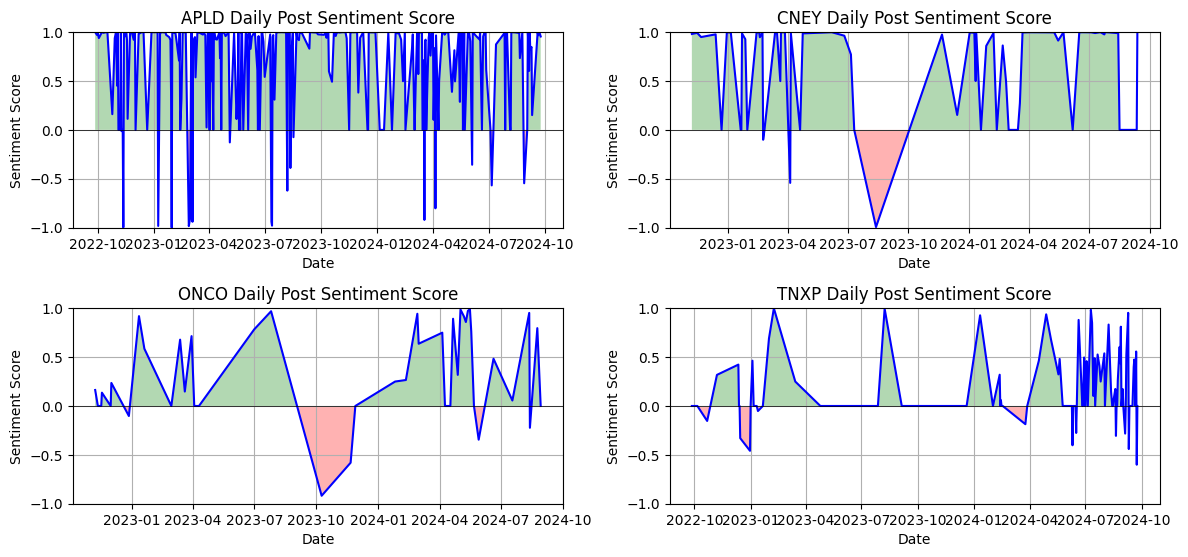

In [170]:
plt.figure(figsize=(12, 8))

# Get unique tickers
unique_tickers = rdf['ticker'].unique()

# Loop through each ticker and create a subplot
for i, ticker in enumerate(unique_tickers):

    # Select the data for the current ticker
    data = rdf[rdf.ticker == ticker]
    
    # Calculate daily mean sentiment
    daily_mean_sentiment = data.groupby('post_date')['post_sentiment'].mean()
    
    # Create subplot for this ticker
    ax = plt.subplot(3, 2, i+1)
    ax.plot(daily_mean_sentiment.index, daily_mean_sentiment, label='Sentiment', color='blue')
    
    # Filling the area between the sentiment scores and zero
    ax.fill_between(daily_mean_sentiment.index, 0, daily_mean_sentiment, where=(daily_mean_sentiment >= 0), facecolor='green', interpolate=True, alpha=0.3)
    ax.fill_between(daily_mean_sentiment.index, 0, daily_mean_sentiment, where=(daily_mean_sentiment <= 0), facecolor='red', interpolate=True, alpha=0.3)
    
    plt.title(f'{ticker} Daily Post Sentiment Score')
    plt.xlabel('Date')
    plt.ylabel('Sentiment Score')
    plt.ylim(-1, 1)  # Set y-axis to show from -1 to 1 for consistency
    plt.grid()
    plt.axhline(0, color='black', linewidth=0.5)  # Add a line at zero

plt.tight_layout()
plt.show()

In [ ]:
#resample dataframes comments_df and rdf daily and join with df on ticker and date
comments_df.set_index('post_date', inplace=True)
rdf.set_index('post_date', inplace=True)

comments_df=comments_df.groupby('Ticker').resample('D').ffill().drop(columns=['Ticker']).reset_index().set_index('Date') #resample data
df.tail()



In [157]:
comments_df.comment_date=comments_df.comment_date.dt.date

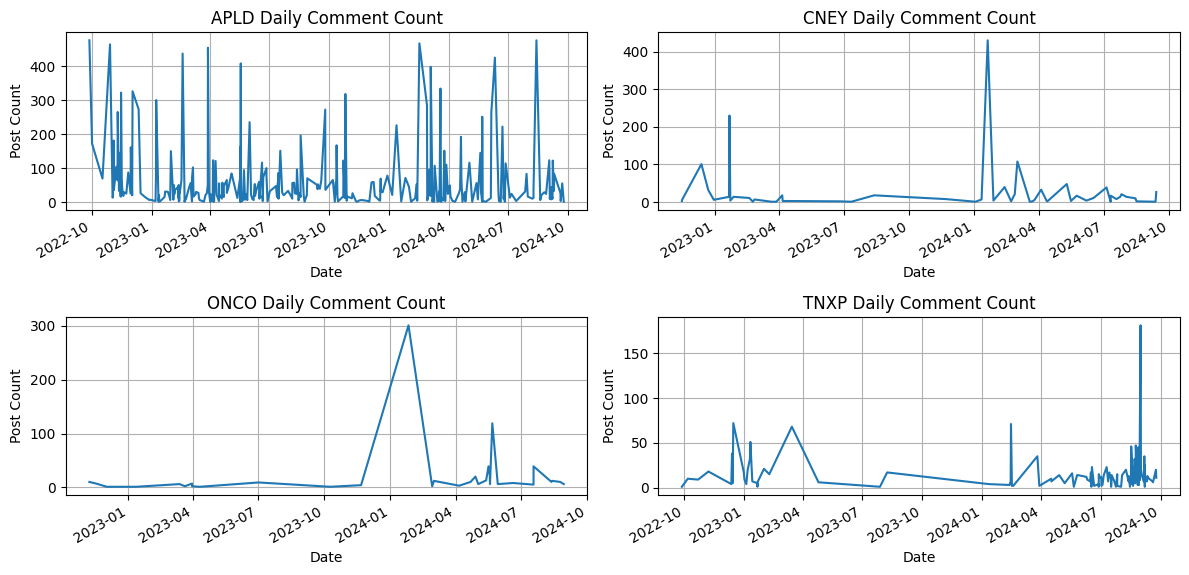

In [162]:
#plot 4 separate bar graphs of daily count of posts by ticker 
plt.figure(figsize=(12, 8))

for i, ticker in enumerate(comments_df.Ticker.unique()):
    plt.subplot(3, 2, i+1)
    comments_df[comments_df.Ticker==ticker].groupby('post_date').size().plot()
    plt.title(f'{ticker} Daily Comment Count')
    plt.xlabel('Date')
    plt.ylabel('Post Count')
    plt.grid()

plt.tight_layout()

plt.show()


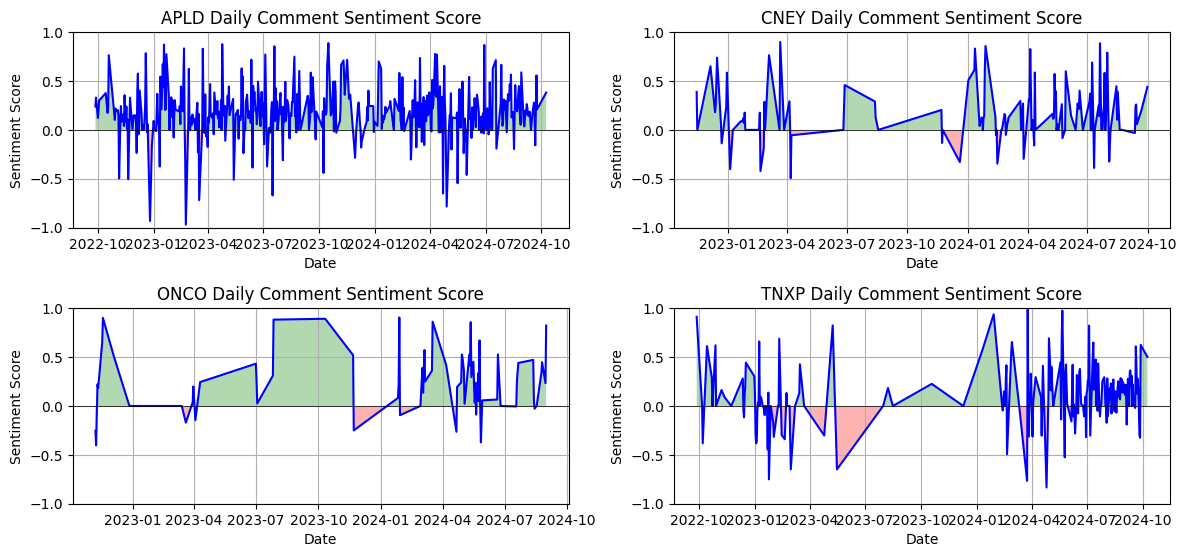

In [175]:
plt.figure(figsize=(12, 8))

# Get unique tickers
unique_tickers = comments_df['Ticker'].unique()

# Loop through each ticker and create a subplot
for i, ticker in enumerate(unique_tickers):

    # Select the data for the current ticker
    data = comments_df[comments_df.Ticker == ticker]
    
    # Calculate daily mean sentiment
    daily_mean_sentiment = data.groupby('comment_date')['comment_sentiment'].mean()
    
    # Create subplot for this ticker
    ax = plt.subplot(3, 2, i+1)
    ax.plot(daily_mean_sentiment.index, daily_mean_sentiment, label='Sentiment', color='blue')
    
    # Filling the area between the sentiment scores and zero
    ax.fill_between(daily_mean_sentiment.index, 0, daily_mean_sentiment, where=(daily_mean_sentiment >= 0), facecolor='green', interpolate=True, alpha=0.3)
    ax.fill_between(daily_mean_sentiment.index, 0, daily_mean_sentiment, where=(daily_mean_sentiment <= 0), facecolor='red', interpolate=True, alpha=0.3)
    
    plt.title(f'{ticker} Daily Comment Sentiment Score')
    plt.xlabel('Date')
    plt.ylabel('Sentiment Score')
    plt.ylim(-1, 1)  # Set y-axis to show from -1 to 1 for consistency
    plt.grid()
    plt.axhline(0, color='black', linewidth=0.5)  # Add a line at zero

plt.tight_layout()
plt.show()

In [153]:
# Resample data by ticker and date, counting the occurrences per day
resampled_data = rdf.groupby('ticker').resample('D').size().unstack(level=0, fill_value=0)

# Plotting
plt.figure(figsize=(14, 8))

# Plot each ticker
for ticker in resampled_data.columns:
    plt.plot(resampled_data.index, resampled_data[ticker], label=ticker)

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Post Count')
plt.title('Post Count Over Time for Each Ticker')
plt.legend(title='Ticker')

# Show the plot
plt.show()

post_date            ticker
2022-09-27 10:28:17  APLD      1
2022-09-27 16:15:25  TNXP      1
2022-09-30 03:12:45  APLD      1
2022-10-01 13:10:55  APLD      1
2022-10-03 15:54:29  APLD      1
                              ..
2024-09-22 11:07:09  APLD      1
2024-09-22 19:40:04  TNXP      1
2024-09-23 14:24:32  TNXP      1
2024-09-24 03:30:04  TNXP      1
2024-09-24 20:26:23  APLD      1
Length: 713, dtype: int64

<Figure size 1200x600 with 0 Axes>

,ticker,subreddit,query,title,score,id,author,url,post_date,post,num_comments,comments
30,APLD,squeezeplays,APLD,$APLD Trading Plan Posted BEFORE The Bell 🚨 - ...,0,13jgxmx,YGLD,https://www.reddit.com/gallery/13jgxmx,2023-05-16 20:54:40,NaN,1,[{'comment': '$CYCN\n$37 Shortsqueeze 700% ! \...
31,APLD,squeezeplays,APLD,$APLD By Far The Greatest Swing Play Of The We...,2,13nhdy5,YGLD,https://i.redd.it/07sq22xr851b1.jpg,2023-05-21 03:17:16,NaN,0,[]
32,APLD,squeezeplays,APLD,Our Top Plays Of The Week 🚨 - We Certainly See...,5,13mi34e,YGLD,https://i.redd.it/o7u176msiy0b1.jpg,2023-05-20 04:40:58,NaN,3,"[{'comment': 'These are reasonable, rational p..."
33,APLD,squeezeplays,APLD,Top Plays Of The Week So Far 🚨 - (Updated Vers...,2,13la5eq,YGLD,https://i.redd.it/iqj9qllozo0b1.jpg,2023-05-18 20:37:51,NaN,3,[{'comment': 'So the plays are worth it? \nLem...
35,APLD,squeezeplays,APLD,Top Plays Of The Week So Far 📈 Much Slower Wee...,0,13ki7e6,YGLD,https://i.redd.it/mjcgjgoesi0b1.jpg,2023-05-17 23:46:24,NaN,0,[]
...,...,...,...,...,...,...,...,...,...,...,...,...
684,TNXP,tnxp,Tonix,Tonix Pharmaceuticals Announces Engagement of ...,1,1aq2q01,Cubegod69er,https://finance.yahoo.com/news/tonix-pharmaceu...,2024-02-13 19:52:17,NaN,4,[{'comment': 'Reverse split incoming for the 1...
696,TNXP,tnxp,Tonix,FDA news 🚀,8,1echiiu,NonoAMS,https://www.reddit.com/r/TNXP/comments/1echiiu...,2024-07-26 06:48:26,TONIX PHARMACEUTICALS GRANTED FAST TRACK DESIG...,15,[{'comment': 'Offering incoming in 3….2…..1….....
697,TNXP,tnxp,Tonix,I hate this position with a passion! But what...,4,1eiggqv,Joey164,https://i.redd.it/koyl7hxfgagd1.jpeg,2024-08-02 17:48:48,NaN,14,[{'comment': 'Yall are fucked. Been watching t...
703,TNXP,tnxp,Tonix,It’s a long hold for me dawg 🤫,3,1e5mw37,Joey164,https://i.redd.it/caq68v33y3dd1.jpeg,2024-07-17 16:42:49,NaN,14,"[{'comment': ""B.S exactly what they said 2022 ..."


In [113]:
def preprocess(text):
    s=

SyntaxError: invalid syntax (2214793544.py, line 2)